#MODELO 3: Φ-SO
Grupo G2B

Integrantes:
- Isidora Godoy
- Diego Brehme

In [ ]:

!pip -q install physo numpy pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE = "/content/drive/MyDrive/nguyen_benchmark_PHI_SO"


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# === Internal code import (como en sr_quick_start) ===
import physo
import physo.learn.monitoring as monitoring

/usr/local/lib/python3.12/dist-packages/physo/physym/program.py:49: UserWarning: Latex display is not available. Issues: shutil.which('latex') returned None
  warnings.warn(msg)


Enforcing spawn multiprocessing start method.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.

Multiprocessing start method : spawn
Running from notebook : True
Is CUDA available : False
Total nb. of CPUs available :  2
Recommended config {'parallel_mode': False, 'n_cpus': 2}
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method 

/usr/local/lib/python3.12/dist-packages/physo/physym/program.py:49: UserWarning: Latex display is not available. Issues: shutil.which('latex') returned None
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/physo/physym/reward.py:252: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [ ]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
import os
import pandas as pd

def load_nguyen_split(func_name: str, split: str, base_dir: str = BASE):
    """
    Carga un CSV de la función `func_name` ('F1'...'F10') y split ('train' o 'test_extrap')
    Soporta dos esquemas:
      1) base_dir/Fi/Fi_train.csv
      2) base_dir/Fi_train.csv
    Devuelve X (n_dim, N), y (N,), y X_names ['x0', ...]
    """
    # Opción 1: subcarpeta por función
    cand1 = os.path.join(base_dir, func_name, f"{func_name}_{split}.csv")
    # Opción 2: todos planos
    cand2 = os.path.join(base_dir, f"{func_name}_{split}.csv")
    fpath = cand1 if os.path.exists(cand1) else cand2
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"No encontré CSV para {func_name} {split} en:\n  {cand1}\n  {cand2}")

    df = pd.read_csv(fpath)
    # Asumimos última columna es y, el resto son features
    X_df = df.iloc[:, :-1]
    y = df.iloc[:, -1].to_numpy().astype(float)
    X = X_df.to_numpy().T.astype(float)  # (n_dim, N)
    X_names = [f"x{i}" for i in range(X.shape[0])]
    return X, y, X_names, fpath


In [ ]:
def plot_dataset(X, y, title="Dataset"):
    n_dim = X.shape[0]
    fig, ax = plt.subplots(n_dim, 1, figsize=(10, 5), squeeze=False)
    for i in range(n_dim):
        curr_ax = ax[i, 0]
        curr_ax.plot(X[i], y, 'k.')
        curr_ax.set_xlabel(f"X[{i}]")
        curr_ax.set_ylabel("y")
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [ ]:
import os

def make_monitors(out_basepath: str):
    """
    En el quick start se usan:
      - save_path_training_curves = 'demo_curves.png'
      - save_path_log = 'demo.log'
    Aquí fabricamos ambos por función, p.ej. F1_curves.png y F1.log
    Además, PhySO guarda un pkl del Pareto con el mismo prefijo que las curvas.
    """
    save_path_training_curves = out_basepath + "_curves.png"
    save_path_log             = out_basepath + ".log"

    run_logger = lambda : monitoring.RunLogger(save_path = save_path_log, do_save = True)
    run_visualiser = lambda : monitoring.RunVisualiser(
        epoch_refresh_rate = 1,
        save_path = save_path_training_curves,
        do_show   = False,
        do_prints = True,
        do_save   = True,
    )
    return run_logger, run_visualiser, save_path_training_curves


In [ ]:
# Para leer el Pareto como en el quick start
from physo.benchmark.utils import symbolic_utils as su
import sympy

def run_physo_on_dataset(func_name: str, X, y, X_names, out_dir: str, epochs: int = 20):
    os.makedirs(out_dir, exist_ok=True)

    # Nombres y unidades (Nguyen: adimensional)
    y_name  = "y"
    zero_u  = [0, 0, 0]  # placeholder de 3 dimensiones; PhySO solo requiere consistencia
    X_units = [zero_u for _ in X_names]
    y_units = zero_u

    # Constantes (puedes ajustar según tu auxiliar; aquí dejamos una fija “1.0”
    # y algunas libres genéricas); todas adimensionales en Nguyen.
    fixed_consts       = [1.0]
    fixed_consts_units = [zero_u]
    free_consts_names  = ["c0", "c1", "c2", "c3"]
    free_consts_units  = [zero_u]*len(free_consts_names)

    # Operadores similares al notebook
    op_names = ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "neg", "exp", "log", "sin", "cos"]

    # Monitores/archivos como el quick start (por función)
    prefix = os.path.join(out_dir, func_name)  # p.ej. .../physo_runs/F1/F1
    get_run_logger, get_run_visualiser, curves_png = make_monitors(prefix)

    # === Running SR task (idéntico espíritu del quick start) ===
    expression, logs = physo.SR(
        X, y,
        X_names = X_names,
        X_units = X_units,
        y_name  = y_name,
        y_units = y_units,
        fixed_consts       = fixed_consts,
        fixed_consts_units = fixed_consts_units,
        free_consts_names  = free_consts_names,
        free_consts_units  = free_consts_units,
        op_names = op_names,
        get_run_logger     = get_run_logger,
        get_run_visualiser = get_run_visualiser,
        run_config = physo.config.config0.config0,  # mismo preset del quick start
        parallel_mode = False,
        epochs = epochs,
    )

    # === Cargar Pareto y elegir la mejor (como hace el quick start) ===
    pareto_pkl = curves_png.replace("_curves.png", "_curves_pareto.pkl")
    # Si por alguna razón cambió el nombre del pkl, revisa la carpeta out_dir
    pareto_expressions = physo.read_pareto_pkl(pareto_pkl)
    best_expr = pareto_expressions[-1]  # la última suele ser la más precisa

    # === Imprimir resultados en los mismos formatos del quick start ===
    print(">>> Pretty infix:")
    print(best_expr.get_infix_pretty())

    print("\n>>> Sympy (estructura simbólica):")
    print(best_expr.get_infix_sympy())

    print("\n>>> Sympy con constantes evaluadas:")
    print(best_expr.get_infix_sympy(evaluate_consts=True)[0])

    print("\n>>> LaTeX (estructura):")
    print(best_expr.get_infix_latex())

    print("\n>>> LaTeX (constantes evaluadas):")
    print(sympy.latex(best_expr.get_infix_sympy(evaluate_consts=True)))

    # Constantes libres (como en quick start)
    print("\n>>> Free constants (objeto):")
    print(best_expr.free_consts)
    print(">>> Free constants values:")
    print(best_expr.free_consts.class_values)

    # === (Opcional) Comprobar equivalencia si conoces la forma “target” ===
    # Ejemplo de cómo lo hace el quick start:
    # target_expr = sympy.simplify("x0 + x0*x1")  # <- AQUI iría la forma correcta de Fi
    # trial_expr  = best_expr.get_infix_sympy(evaluate_consts=True)[0]
    # is_equivalent, log = su.compare_expression(
    #     trial_expr  = trial_expr,
    #     target_expr = target_expr,
    #     handle_trigo=True,
    #     prevent_zero_frac=True,
    #     prevent_inf_equivalence=True,
    #     verbose=True,
    # )
    # print("Is equivalent:", is_equivalent)

    return best_expr, pareto_expressions, (prefix + "_curves.png"), (prefix + ".log"), pareto_pkl


### F1: cargando TRAIN y ejecutando SR
Train CSV: /content/drive/MyDrive/nguyen_benchmark_PHI_SO/F1_train.csv


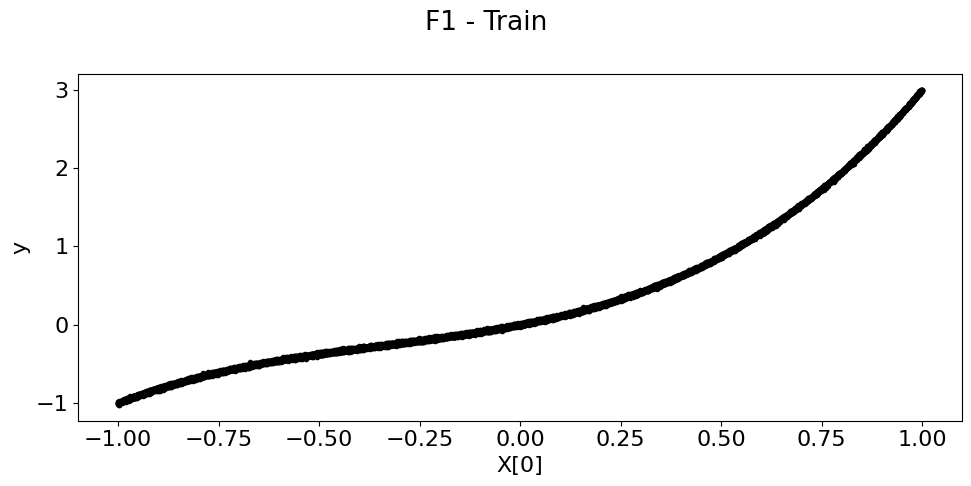

Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
SR task started...


/usr/local/lib/python3.12/dist-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)


=========== Epoch 00000 ===========
-> Time 4.08 s
-> Memory Usage: 1047.74 MB

Overall best  at R=0.927609
-> Raw expression : 
⎛                         2⎞          
⎜        2⎛             2⎞ ⎟ 1        
⎝x₀ + log ⎝(-c₁⋅x₀ + c₃) ⎠ ⎠⋅──⋅1.0⋅c₁
                             c₁       

Best of epoch at R=0.927609
-> Raw expression : 
⎛                         2⎞          
⎜        2⎛             2⎞ ⎟ 1        
⎝x₀ + log ⎝(-c₁⋅x₀ + c₃) ⎠ ⎠⋅──⋅1.0⋅c₁
                             c₁       


=========== Epoch 00001 ===========
-> Time 153.49 s
-> Memory Usage: 1201.58 MB

Overall best  at R=0.927609
-> Raw expression : 
⎛                         2⎞          
⎜        2⎛             2⎞ ⎟ 1        
⎝x₀ + log ⎝(-c₁⋅x₀ + c₃) ⎠ ⎠⋅──⋅1.0⋅c₁
                             c₁       

Best of epoch at R=0.899817
-> Raw expression : 
                                             2 
      ⎛             ⎛                     2⎞⎞  
     -⎝c₀ - c₂ + sin⎝(-x₀ + log(c₁) - 1.0) ⎠⎠  
x₀ - ─────────────────────

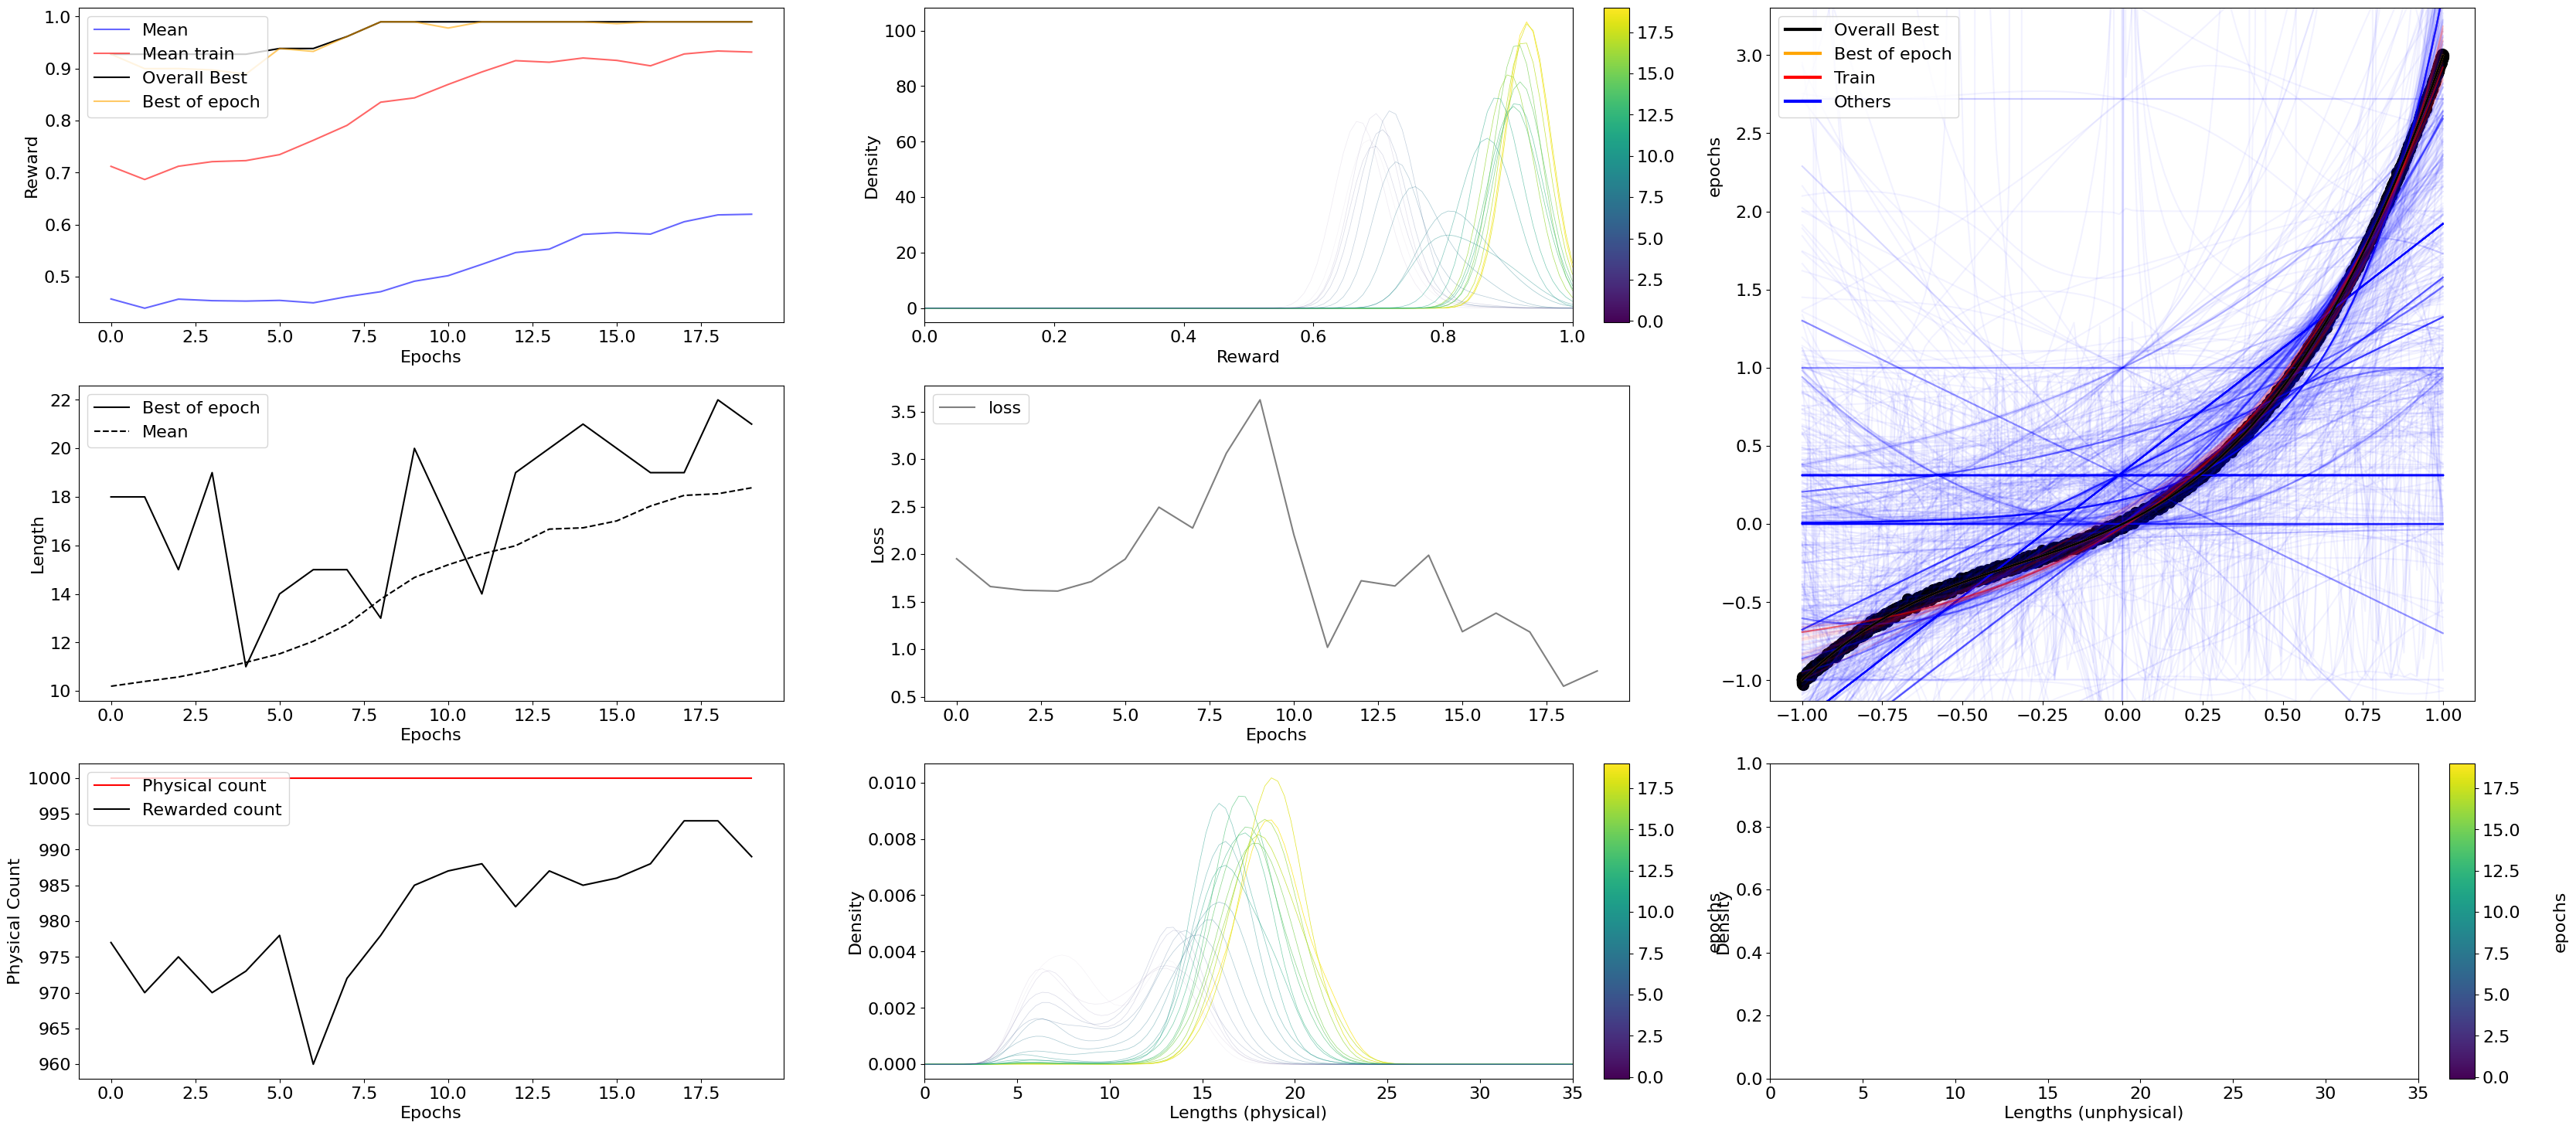

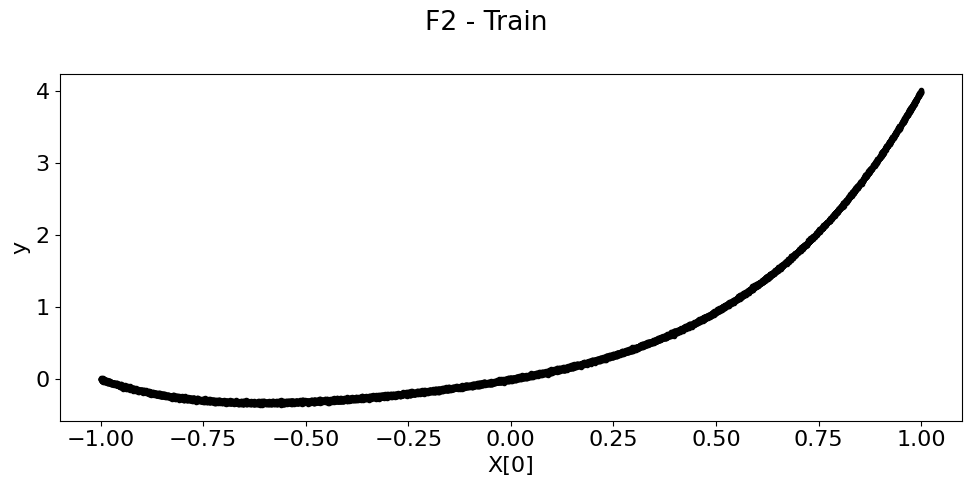

Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
SR task started...


/usr/local/lib/python3.12/dist-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)


=========== Epoch 00000 ===========
-> Time 3.64 s
-> Memory Usage: 1361.23 MB

Overall best  at R=0.891286
-> Raw expression : 
   ⎛     2                                  ⎞
   ⎜⎛ x₀⎞                                   ⎟
c₁⋅⎝⎝ℯ  ⎠  - cos(c₂⋅(c₂ - (-c₁ + c₁ + 1.0)))⎠

Best of epoch at R=0.891286
-> Raw expression : 
   ⎛     2                                  ⎞
   ⎜⎛ x₀⎞                                   ⎟
c₁⋅⎝⎝ℯ  ⎠  - cos(c₂⋅(c₂ - (-c₁ + c₁ + 1.0)))⎠


=========== Epoch 00001 ===========
-> Time 145.30 s
-> Memory Usage: 1361.25 MB

Overall best  at R=0.892274
-> Raw expression : 
               1               
───────────────────────────────
⎛                          0.5⎞
⎜ -c₁ + (log(x₀) + cos(c₀))   ⎟
⎜ ────────────────────────────⎟
⎜           -c₂ + x₀          ⎟
⎜ℯ                            ⎟
⎜─────────────────────────────⎟
⎝            c₃⋅x₀            ⎠

Best of epoch at R=0.892274
-> Raw expression : 
               1               
───────────────────────────────
⎛         

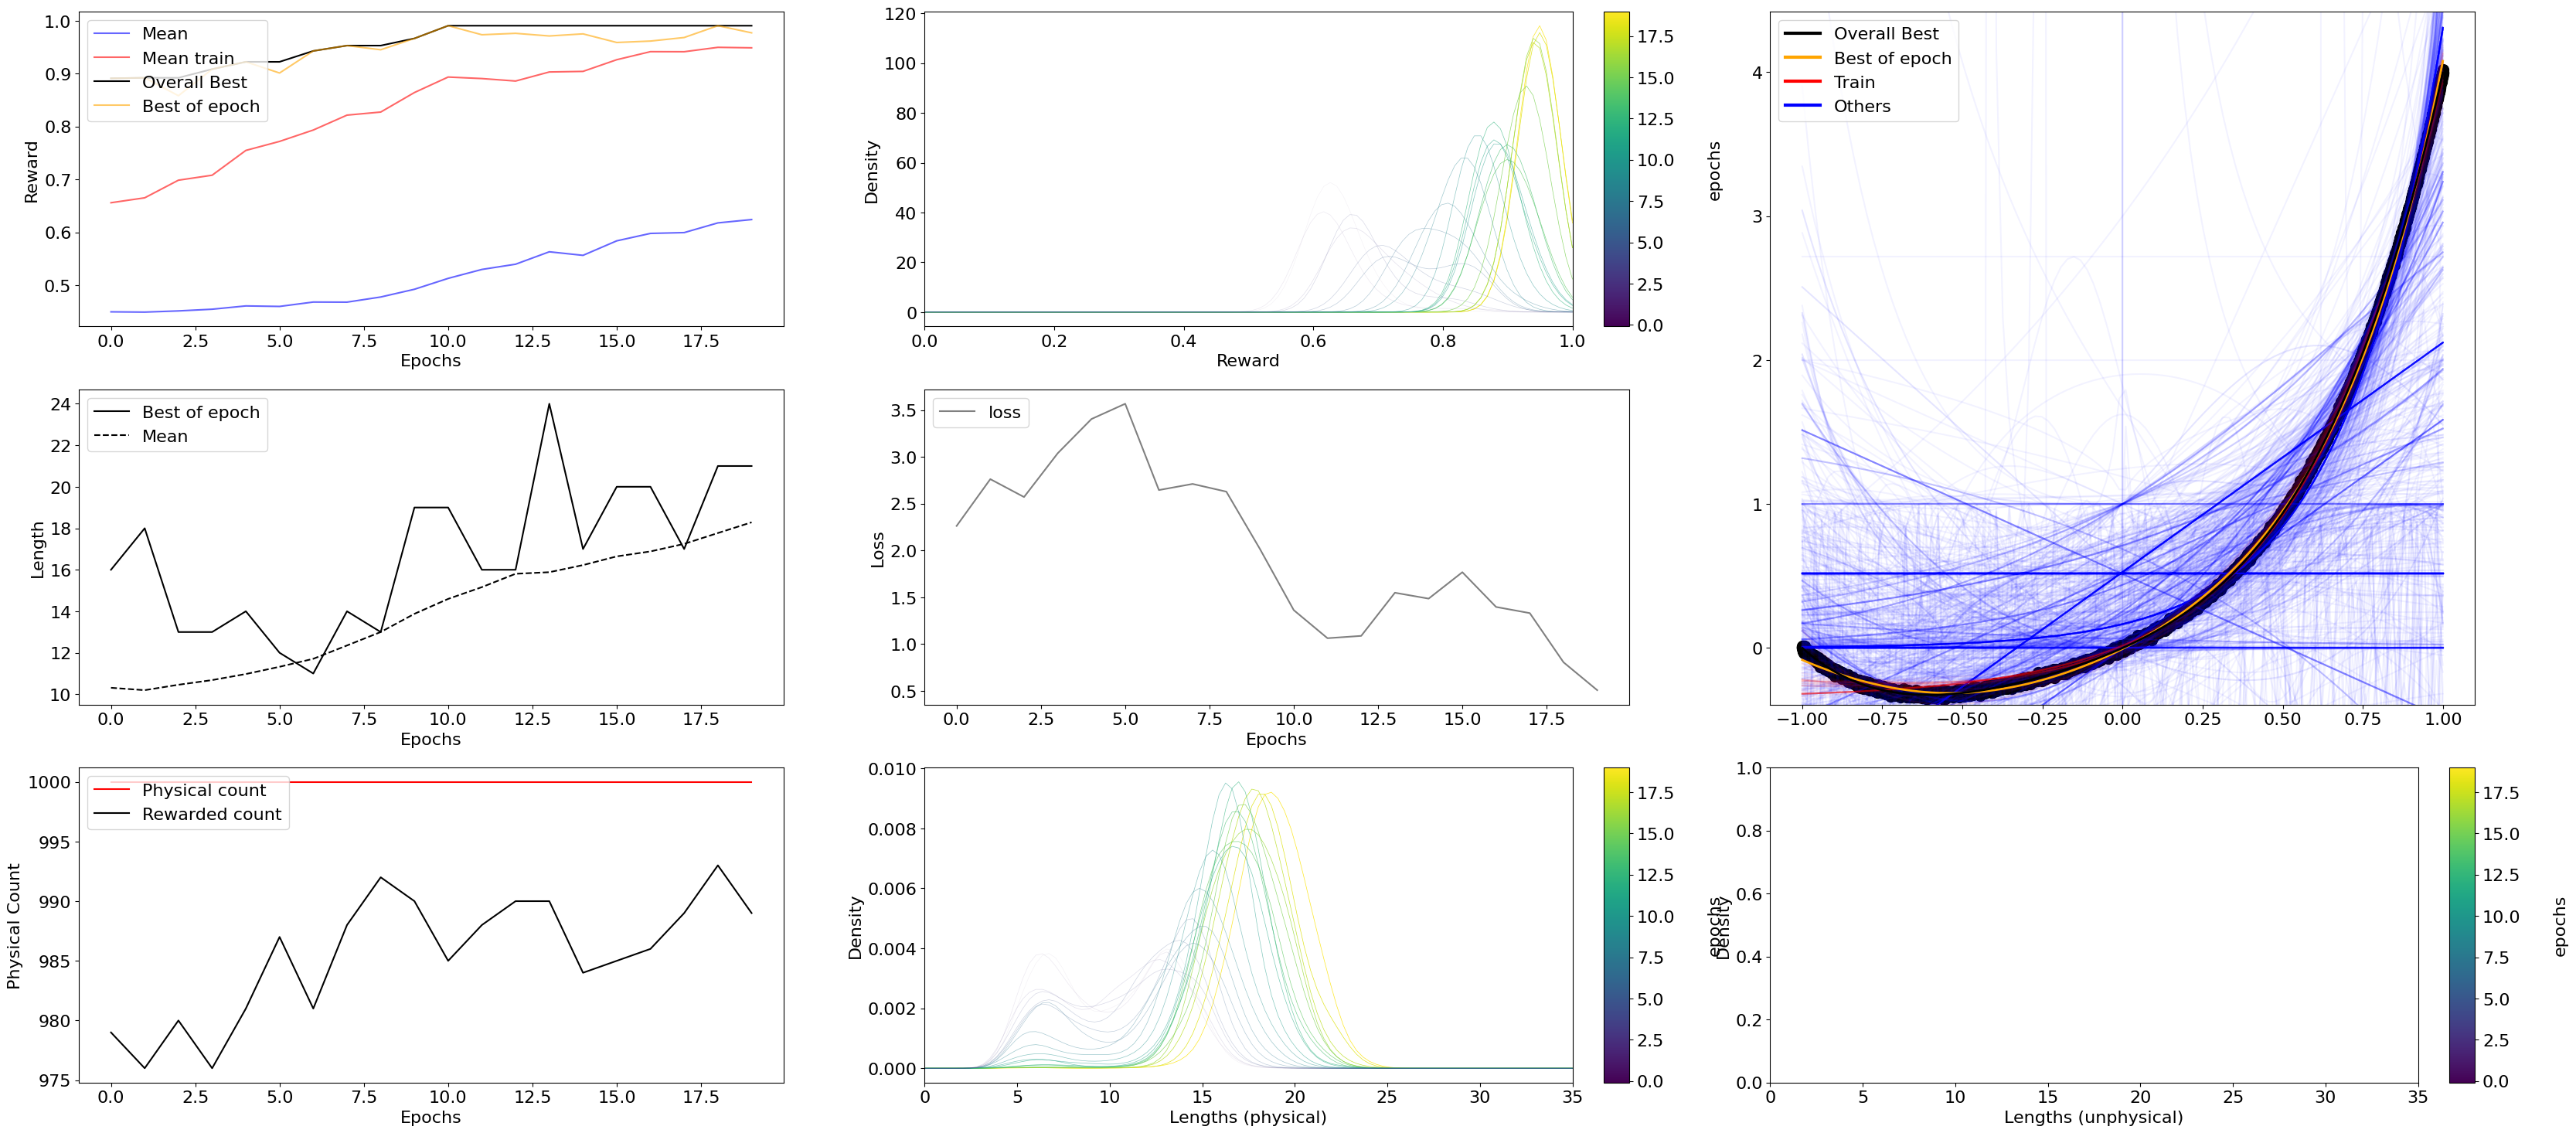

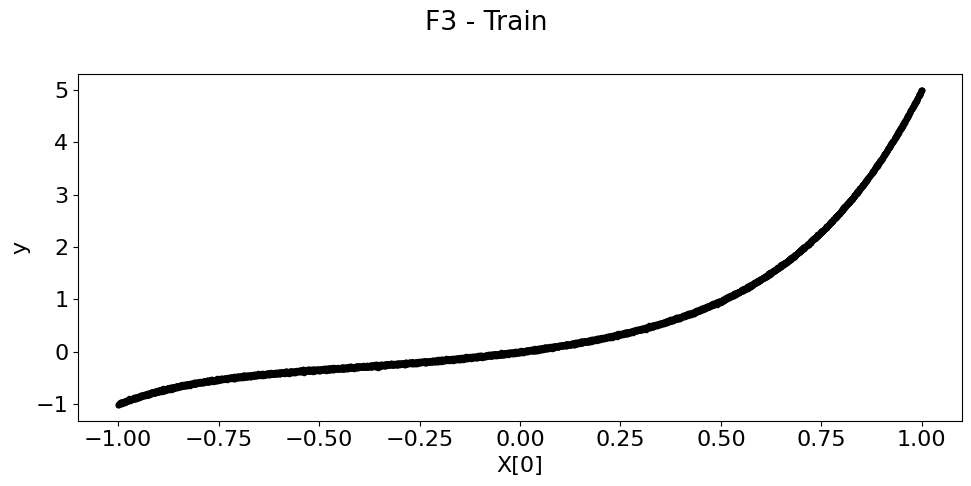

Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
SR task started...


/usr/local/lib/python3.12/dist-packages/physo/physym/batch_execute.py:80: UserWarning: Parallel mode is not available because physo is being ran from a notebook using 'spawn' multiprocessing start method (multiprocessing.get_start_method() = 'spawn'). Run physo from a python script to use parallel mode.
  warnings.warn(msg)


=========== Epoch 00000 ===========
-> Time 4.97 s
-> Memory Usage: 1434.37 MB

Overall best  at R=0.913700
-> Raw expression : 
   ⎛                                     2⎞
   ⎜⎛     ⎛   ⎛   1    ⎞        1      ⎞⎞ ⎟
log⎜⎜c₃ - ⎜cos⎜────────⎟ - ────────────⎟⎟ ⎟
   ⎜⎜     ⎜   ⎜ ⎛  0.5⎞⎟             x₀⎟⎟ ⎟
   ⎜⎜     ⎜   ⎜ ⎝c₁   ⎠⎟   c₁ + c₂ - ──⎟⎟ ⎟
   ⎝⎝     ⎝   ⎝ℯ       ⎠             c₀⎠⎠ ⎠

Best of epoch at R=0.913700
-> Raw expression : 
   ⎛                                     2⎞
   ⎜⎛     ⎛   ⎛   1    ⎞        1      ⎞⎞ ⎟
log⎜⎜c₃ - ⎜cos⎜────────⎟ - ────────────⎟⎟ ⎟
   ⎜⎜     ⎜   ⎜ ⎛  0.5⎞⎟             x₀⎟⎟ ⎟
   ⎜⎜     ⎜   ⎜ ⎝c₁   ⎠⎟   c₁ + c₂ - ──⎟⎟ ⎟
   ⎝⎝     ⎝   ⎝ℯ       ⎠             c₀⎠⎠ ⎠


=========== Epoch 00001 ===========
-> Time 139.84 s
-> Memory Usage: 1434.37 MB

Overall best  at R=0.927535
-> Raw expression : 
       ⎛           ⎛1 ⎞⎞          
    sin⎜c₂ + x₀⋅log⎜──⎟⎟ + cos(c₀)
       ⎝           ⎝c₁⎠⎠          
x₀⋅ℯ                              

Best of epoch at R=

In [ ]:
functions = [f"F{i}" for i in range(1, 11)]
results = {}

for func in functions:
    print("="*80)
    print(f"### {func}: cargando TRAIN y ejecutando SR")
    # Cargar TRAIN
    X_tr, y_tr, X_names, path_tr = load_nguyen_split(func, "train", BASE)
    print(f"Train CSV: {path_tr}")
    plot_dataset(X_tr, y_tr, title=f"{func} - Train")

    # Carpeta de salida por función (igual filosofía del quick start de un solo prefijo por corrida)
    out_dir = os.path.join(BASE, "physo_runs", func)

    # Correr SR (ajusta epochs si quieres una búsqueda más larga)
    best_expr, pareto, curves_png, log_path, pareto_pkl = run_physo_on_dataset(
        func_name = func,
        X = X_tr,
        y = y_tr,
        X_names = X_names,
        out_dir = out_dir,
        epochs = 20,   # igual que el quick start; sube si quieres mejor ajuste
    )

    # (Opcional) Evaluación en test_extrap si existe
    try:
        X_te, y_te, X_names_te, path_te = load_nguyen_split(func, "test_extrap", BASE)
        print(f"\n{func}: encontrado TEST_EXTRAP => {path_te}")
        # Eval rápida: transformamos la expresión simbólica en función NumPy
        sym_expr = best_expr.get_infix_sympy(evaluate_consts=True)[0]
        vars_syms = [sympy.Symbol(n) for n in X_names]
        f_lam = sympy.lambdify(vars_syms, sym_expr, "numpy")
        y_pred = f_lam(*[X_te[i, :] for i in range(X_te.shape[0])])
        # Métrica simple (NRMSE):
        nrmse = np.sqrt(np.mean((y_pred - y_te)**2)) / (np.max(y_te) - np.min(y_te) + 1e-12)
        print(f"{func} | NRMSE (test_extrap): {nrmse:.4e}")
    except FileNotFoundError:
        print(f"{func}: no se encontró test_extrap; omitiendo evaluación.")

    results[func] = dict(
        best_expr_pretty = best_expr.get_infix_pretty(),
        curves_png = curves_png,
        log_path = log_path,
        pareto_pkl = pareto_pkl,
    )

print("\n\n>>> RESUMEN (pretty infix por función):")
for k, v in results.items():
    print(f"{k}: {v['best_expr_pretty']}")
